In [1]:
!git clone https://github.com/yujiafeng8888/scCNA.git
%cd scCNA
!pip install .
!pip install infercnvpy

Cloning into 'scCNA'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 91 (delta 12), reused 10 (delta 4), pack-reused 66 (from 1)
Receiving objects: 100% (91/91), 42.40 MiB | 61.15 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/scCNA
Processing /content/scCNA
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.0 MB/s eta 0:00:00
  Created wheel for scCNA: filename=scCNA-0.1-py3-none-any.whl size=6090 sha256=a266987deb04522535c1d9d86218e89b31edfa83f8351aa41bae7e0f13fc51fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-o45n79ez/wheels/25/cc/c5/ae548f3a909d160258148b54a2721305eb2d68474f5650137

In [3]:
import scanpy as sc
import scCNA as cna
import matplotlib.pyplot as plt
import infercnvpy as cnv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
adata = sc.read_h5ad("/content/drive/MyDrive/PBMC_simulated_cnas_041025.h5ad")

Mounted at /content/drive


In [4]:
ad_def = cna.find_cnas(
    adata.copy(),
    reference_key='cell_type',
    reference_cat=[
        'CD4 T cell','CD14 monocyte','B cell','CD8 T cell',
        'NK cell','FCGR3A monocyte','Dendritic','Megakaryocyte'
    ],
    threshold=5,
    min_cells=20,
    window_size=100
)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
print(ad_def.shape)

(10309, 19693)


**Calculate the**

In [6]:
y_true = (ad_def.obs['simulated_cnvs'].notna()) & (ad_def.obs['simulated_cnvs'] != '')
#y_pred = (ad_def.obs['detect_CNA'].notna()) & (ad_def.obs['detect_CNA'] != '')
y_pred = ad_def.obs['detect_CNA'].apply(lambda x: x != 'none' and isinstance(x, str))

print("=== Cell-level Binary Classification Metrics ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("PR-AUC   :", average_precision_score(y_true, y_pred))

=== Cell-level Binary Classification Metrics ===
Accuracy : 0.36793093413522165
Precision: 0.351875808538163
Recall   : 0.7485614210657994
F1 Score : 0.47872
PR-AUC   : 0.3608882874440729


In [7]:
print(y_pred.value_counts())
print(y_true.value_counts())

detect_CNA
True     8503
False    1806
Name: count, dtype: int64
simulated_cnvs
False    6312
True     3997
Name: count, dtype: int64


In [9]:
thresholds = [1, 3, 10]
results = []

for threshold in thresholds:
    adata_tmp = cna.find_cnas(
        adata.copy(),
        reference_key='cell_type',
        reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                       'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
        threshold=threshold,
        min_cells=20,
        window_size=100
    )

    y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
    y_pred = ad_def.obs['detect_CNA'].apply(lambda x: x != 'none' and isinstance(x, str))


    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((thresholds, acc, prec, rec, f1, pr_auc))


results.sort(key=lambda x: -x[4])

# print("window_size Parameter evaluation result:")
# print(f"{'Window':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
# for r in results:
#     print(f"{r[0]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")

# results.sort(key=lambda x: -x[1])
# print("Threshold sweep results (F1 score):")
# for r in results:
#     print(f"Threshold={r[0]} → F1 Score={r[1]:.3f}")


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
print("Threshold sweep results:")
print(f"{'Threshold':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for i, r in enumerate(results):
    print(f"{thresholds[i]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")


Threshold sweep results:
Threshold  Acc      Prec     Recall   F1       PR-AUC  
1          0.368    0.352    0.749    0.479    0.361
3          0.368    0.352    0.749    0.479    0.361
10         0.368    0.352    0.749    0.479    0.361


In [14]:
min_cells_list = [5, 10, 25]
results = []

for min_cells in min_cells_list:
    adata_tmp = cna.find_cnas(
        adata.copy(),
        reference_key='cell_type',
        reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                       'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
        threshold=2,
        min_cells=min_cells,
        window_size=100
    )

    y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
    y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((min_cells, acc, prec, rec, f1, pr_auc))


# results.sort(key=lambda x: -x[4])
# print("min_cells Parameter Evaluation:")
# print(f"{'MinCells':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
# for r in results:
#     print(f"{r[0]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
print("Min_cells sweep results:")
print(f"{'Min_cells':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for i, r in enumerate(results):
    print(f"{min_cells_list[i]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")

Min_cells sweep results:
Min_cells  Acc      Prec     Recall   F1       PR-AUC  
5          0.388    0.388    1.000    0.559    0.388
10         0.388    0.388    1.000    0.559    0.388
25         0.388    0.388    1.000    0.559    0.388


In [16]:
window_sizes = [100, 150, 250]
min_cells_list = [5, 10, 25]
results = []

for window_size in window_sizes:
    for min_cells in min_cells_list:
        adata_tmp = cna.find_cnas(
            adata.copy(),
            reference_key='cell_type',
            reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                           'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
            threshold=2,
            min_cells=min_cells,
            window_size=window_size
        )

        y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
        y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)

        results.append((window_size, min_cells, acc, prec, rec, f1, pr_auc))


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata

In [17]:
print("Sweep results for window_size × min_cells:")
print(f"{'WinSize':<10} {'MinCells':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for r in results:
    print(f"{r[0]:<10} {r[1]:<10} {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}    {r[6]:.3f}")


Sweep results for window_size × min_cells:
WinSize    MinCells   Acc      Prec     Recall   F1       PR-AUC  
100        5          0.388    0.388    1.000    0.559    0.388
100        10         0.388    0.388    1.000    0.559    0.388
100        25         0.388    0.388    1.000    0.559    0.388
150        5          0.388    0.388    1.000    0.559    0.388
150        10         0.388    0.388    1.000    0.559    0.388
150        25         0.388    0.388    1.000    0.559    0.388
250        5          0.388    0.388    1.000    0.559    0.388
250        10         0.388    0.388    1.000    0.559    0.388
250        25         0.388    0.388    1.000    0.559    0.388


In [29]:
print(f"Window={window_size}, MinCells={min_cells}")
print("detect_CNA value counts:")
print(adata_tmp.obs['detect_CNA'].value_counts(dropna=False))
print("simulated_cnvs value counts:")
print(adata_tmp.obs['simulated_cnvs'].value_counts(dropna=False))
print("-" * 50)

Window=250, MinCells=25
detect_CNA value counts:
detect_CNA
1:89551.0-19882395.0_gain;1:20111939.0-37474580.0_gain;1:37489993.0-61742477.0_gain;1:62194790.0-111448864.0_gain;1:111473792.0-154220179.0_gain;1:154272355.0-172370189.0_gain;1:172532349.0-212035553.0_gain;1:212285410.0-248906196.0_gain;2:38814.0-41935368.0_gain;2:42048021.0-85605254.0_gain;2:85657314.0-130571659.0_gain;2:130836914.0-196763035.0_gain;2:196833004.0-237421420.0_gain;2:237612977.0-242087351.0_gain;3:196763.0-44729596.0_gain;3:44737661.0-71567863.0_gain;3:71581601.0-133746040.0_gain;3:133784023.0-190322541.0_gain;3:190514051.0-197960200.0_gain;4:53286.0-56467617.0_gain;4:56505209.0-127840198.0_gain;4:127880893.0-189940855.0_gain;5:92168.0-74721206.0_gain;5:74766991.0-134738495.0_gain;5:134758771.0-175796310.0_gain;5:175917873.0-181306502.0_gain;6:31200165.0-63719980.0_gain;6:63805797.0-135991936.0_gain;6:136231024.0-170575295.0_gain;7:76890.0-43875894.0_gain;7:43926436.0-100119634.0_gain;7:100126785.0-141656728.0

In [28]:
print(f"Window={window_size}, MinCells={min_cells}")
print("Mean of first 10 cells' X:", adata_tmp.X[:10].mean())
print("-" * 50)

Window=250, MinCells=25
Mean of first 10 cells' X: 0.5636879
--------------------------------------------------


In [ ]:
window_sizes = [100, 150, 250]
results = []

for window_size in window_sizes:
    adata_tmp = cna.find_cnas(
        adata.copy(),
        reference_key='cell_type',
        reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                       'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
        threshold=2,
        min_cells=10,
        window_size=window_size
    )

    y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
    y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((window_size, acc, prec, rec, f1, pr_auc))


# results.sort(key=lambda x: -x[4])
# print("window_size Parameter Evaluation:")
# print(f"{'Window':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
# for r in results:
#     print(f"{r[0]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")


In [ ]:
print("Window size sweep results:")
print(f"{'Window':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for i, r in enumerate(results):
    print(f"{window_sizes[i]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")


In [24]:
depths = [500,1000, 2000, 3000,4000,5000]
results = []

for d in depths:
    ad_sub = sc.pp.subsample(adata, n_obs=d, copy=True)
    ad_sub = cna.find_cnas(
        ad_sub,
        reference_key='cell_type',
        reference_cat=[
            'CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
            'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'
        ],
        threshold=5,
        min_cells=20,
        window_size=100
    )

    y_true = (ad_sub.obs['simulated_cnvs'].notna()) & (ad_sub.obs['simulated_cnvs'] != '')
    y_pred = ad_sub.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((d, acc, prec, rec, f1, pr_auc))
    #print(f"Read Depth={d} → Acc={acc:.3f}, Prec={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, PR-AUC={pr_auc:.3f}")

# print("\nSummary of performance at different read depths:")
# print(f"{'Depth':<8} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
# for r in results:
#     print(f"{r[0]:<8} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")

# depths = [r[0] for r in results]
# f1_scores = [r[4] for r in results]
# plt.plot(depths, f1_scores, marker='o')
# plt.xlabel("Read Depth (Number of Cells)")
# plt.ylabel("F1 Score")
# plt.title("F1 Score vs Read Depth")
# plt.grid(True)
# plt.show()


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata


Summary of performance at different read depths:
Depth    Acc     Prec    Recall  F1      PR-AUC 
--------------------------------------------------
500      0.356   0.322   0.618   0.423   0.345  
1000     0.380   0.354   0.722   0.475   0.364  
2000     0.368   0.348   0.682   0.460   0.363  
3000     0.371   0.345   0.711   0.465   0.357  
4000     0.368   0.346   0.726   0.468   0.356  
5000     0.369   0.349   0.725   0.471   0.360  


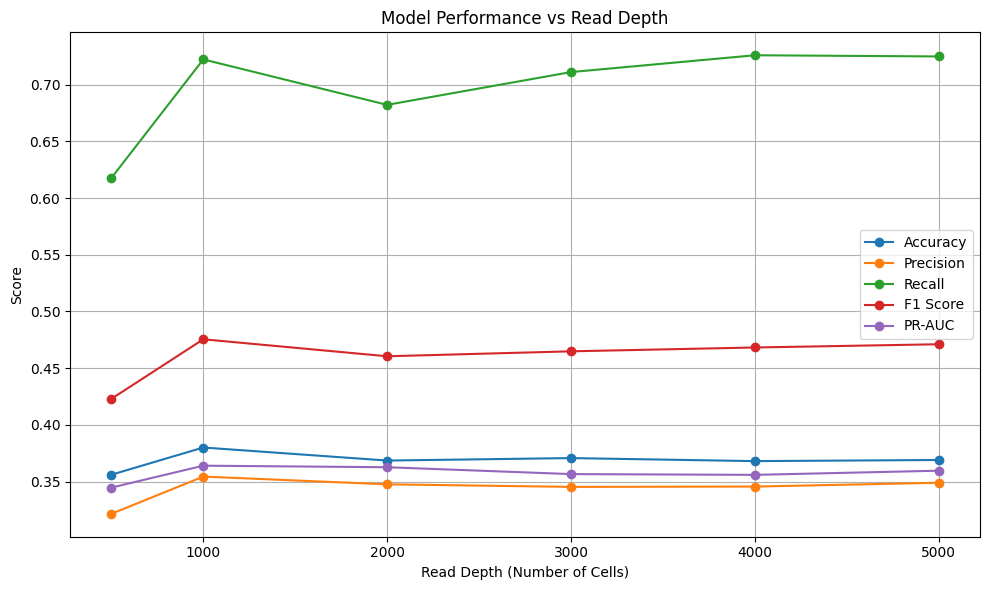

In [26]:
print("\nSummary of performance at different read depths:")
print(f"{'Depth':<8} {'Acc':<7} {'Prec':<7} {'Recall':<7} {'F1':<7} {'PR-AUC':<7}")
print("-" * 50)
for r in results:
    print(f"{r[0]:<8} {r[1]:<7.3f} {r[2]:<7.3f} {r[3]:<7.3f} {r[4]:<7.3f} {r[5]:<7.3f}")

depths = [r[0] for r in results]
acc = [r[1] for r in results]
prec = [r[2] for r in results]
recall = [r[3] for r in results]
f1 = [r[4] for r in results]
pr_auc = [r[5] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', label='Accuracy')
plt.plot(depths, prec, marker='o', label='Precision')
plt.plot(depths, recall, marker='o', label='Recall')
plt.plot(depths, f1, marker='o', label='F1 Score')
plt.plot(depths, pr_auc, marker='o', label='PR-AUC')

plt.xlabel("Read Depth (Number of Cells)")
plt.ylabel("Score")
plt.title("Model Performance vs Read Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
